# Random Forest Training 

This notebook trains a Random Forest 

**Key Features:**
- SMOTE 
- Comprehensive preprocessing and feature engineering
- Data leakage diagnostics
- Feature importance analysis

## 1. Setup and Imports

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from CICIDS2017.dataset import CICIDS2017
from UNSWNB15.dataset import UNSWNB15

from scripts.models.model_utils import (
    check_data_leakage,
    get_tree_feature_importance    
)

# Import model-specific modules
from scripts.models.random_forest.random_forest import train_random_forest

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Imports successful")

Imports successful


## 2. Initialize Logger

In [2]:
logger = LoggerManager(
    root_dir=root_dir,
    log_name="rf_notebook"
).get_logger()
logger.info("Starting Random Forest training notebook")

2025-11-26 09:14:54,600 - INFO - Starting Random Forest training notebook


## 3. Load and Preprocess Data

In [3]:
logger.info("Loading CICIDS2017 dataset...")
dataset = CICIDS2017(logger=logger).optimize_memory().encode().subset(size=100000, multi_class=True)

2025-11-26 09:14:54,615 - INFO - Loading CICIDS2017 dataset...
2025-11-26 09:14:54,616 - INFO - Downloading dataset: sweety18/cicids2017-full-dataset
2025-11-26 09:14:55,204 - INFO - Loading dataset into DataFrame
2025-11-26 09:15:08,240 - INFO - Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
2025-11-26 09:15:23,933 - INFO - ============================================================
2025-11-26 09:15:23,933 - INFO - Preprocessing completed successfully
2025-11-26 09:15:23,934 - INFO - Final dimensions: 1,940,693 rows x 71 columns
2025-11-26 09:15:23,935 - INFO - Total rows removed: 273,776 (12.36%)
2025-11-26 09:15:23,935 - INFO - data retention rate: 87.64%
2025-11-26 09:15:23,936 - INFO - ============================================================
2025-11-26 09:15:23,937 - INFO - Optimizing memory usage of the dataset...
2025-11-26 09:15:23,940 - INFO - Initial memory usage: 1066.05 MB
2025-11-26 09:15:24,624 - INFO - Optimized memory usage: 555.24 MB
2025-11-2

## 4. Visualize Class Distribution

In [4]:
dataset.distribution()

2025-11-26 09:15:25,620 - INFO - Calculating data distribution...
2025-11-26 09:15:25,621 - INFO - Data Distribution by Attack Type:
2025-11-26 09:15:25,622 - INFO -   0: 25,000 instances
2025-11-26 09:15:25,622 - INFO -   1: 25,000 instances
2025-11-26 09:15:25,622 - INFO -   2: 25,000 instances
2025-11-26 09:15:25,623 - INFO -   3: 25,000 instances


0    25000
1    25000
2    25000
3    25000
Name: count, dtype: int64

## 5. Data Leakage Diagnostics

In [5]:
# Check for potential data leakage
#diagnostics = check_data_leakage(X, y, logger=logger)

## 6. Train/Test Split

In [6]:
# Split data
X_train, X_test, y_train, y_test = dataset.split(test_size=0.2, apply_smote=True)
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

2025-11-26 09:15:25,640 - INFO - Splitting dataset into training and testing sets...
2025-11-26 09:15:26,183 - INFO - Class distribution before SMOTE:
2025-11-26 09:15:26,184 - INFO -   Class 0.0: 20068 samples
2025-11-26 09:15:26,184 - INFO -   Class 1.0: 20009 samples
2025-11-26 09:15:26,185 - INFO -   Class 2.0: 19899 samples
2025-11-26 09:15:26,185 - INFO -   Class 3.0: 20024 samples
2025-11-26 09:15:26,186 - INFO - Class distribution after SMOTE:
2025-11-26 09:15:26,186 - INFO -   Class 0.0: 20068 samples
2025-11-26 09:15:26,187 - INFO -   Class 1.0: 20009 samples
2025-11-26 09:15:26,188 - INFO -   Class 2.0: 19899 samples
2025-11-26 09:15:26,188 - INFO -   Class 3.0: 20024 samples


Train set shape: (80000, 70)
Test set shape: (20000, 70)


## 7. Cross-Validation and training

### What does Step 11 (Cross-Validation) do?

In this step, we use 5-fold cross-validation to estimate how well our Random Forest pipeline will generalize to new, unseen data. The process works by splitting the training data into 5 parts (folds), training the model on 4 parts, and validating it on the remaining part. This is repeated so each part is used as a validation set once. The average accuracy across all folds gives us a robust measure of model performance before we evaluate on the true test set.

**Why is this important?**
- It helps detect overfitting or underfitting.
- It allows us to compare different model settings fairly.
- It provides a realistic estimate of how the model will perform in practice, using only the training data.
- **Importantly, the real test set is never touched during cross-validation.** This ensures our final evaluation is unbiased and reflects true out-of-sample performance.

In [7]:
# Train Random Forest using standalone function and plot CV scores
logger.info("Training Random Forest with cross-validation using train_random_forest...")
rf_model, cv_scores = train_random_forest(
    X_train,
    y_train,
    n_estimators=10,
    max_depth=3,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=0,
    cv=5,
    class_weight='balanced',
    logger=None
)
if cv_scores!= None:
    print("\n" + "="*50)
    print("CROSS-VALIDATION RESULTS")
    print("="*50)
    print(f"CV Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    # Plot CV scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cv_scores)+1), cv_scores, marker='o', markersize=10, linewidth=2, color='green')
    plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', 
                label=f'Mean: {cv_scores.mean():.4f}')
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Decision Tree Cross-Validation Scores', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

2025-11-26 09:15:26,198 - INFO - Training Random Forest with cross-validation using train_random_forest...


## 8. Evaluate on Test Set

2025-11-26 09:15:43,730 - INFO - Running analysis for scikit-learn model: RandomForest


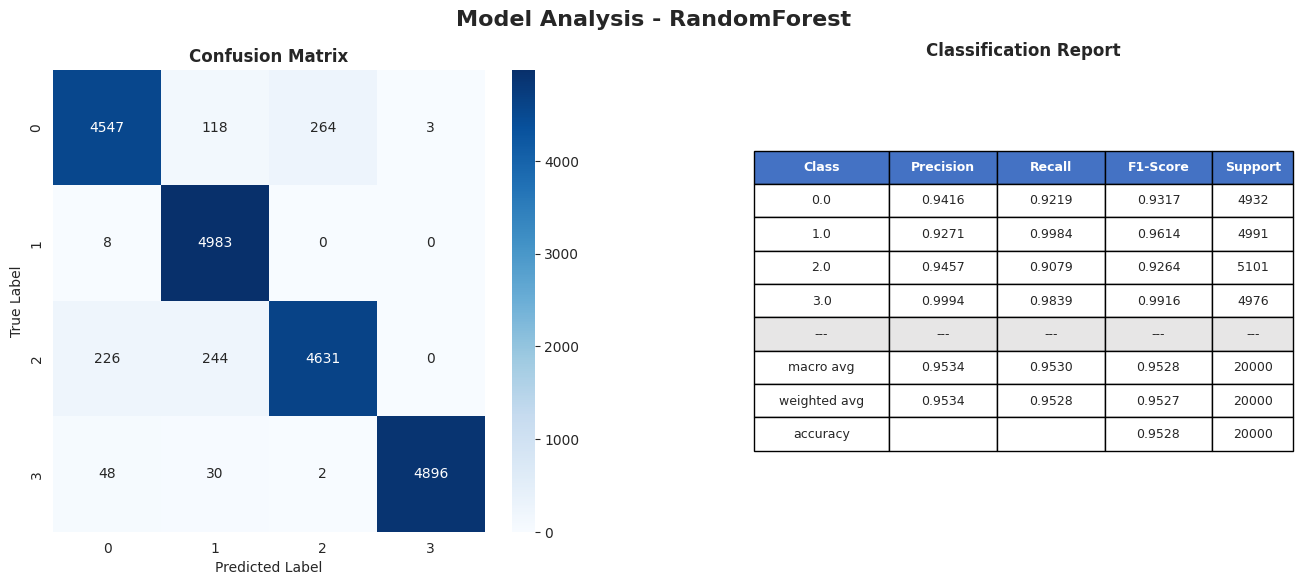

In [9]:
# Evaluate model
cm, cr = perform_model_analysis(
    model=rf_model,
    X_test=X_test,
    y_test=y_test,
    logger=logger,
    title="RandomForest",
    root_dir=root_dir,
    plot=True
)

## 9. Feature Importance Analysis

2025-11-26 09:15:47,707 - INFO - Top 15 most important features:
2025-11-26 09:15:47,708 - INFO - 1. Subflow Fwd Bytes: 0.1104
2025-11-26 09:15:47,708 - INFO - 2. Fwd Packet Length Max: 0.1091
2025-11-26 09:15:47,709 - INFO - 3. Total Length of Fwd Packets: 0.0929
2025-11-26 09:15:47,709 - INFO - 4. Idle Mean: 0.0751
2025-11-26 09:15:47,710 - INFO - 5. Average Packet Size: 0.0741
2025-11-26 09:15:47,711 - INFO - 6. Bwd Packets/s: 0.0661
2025-11-26 09:15:47,711 - INFO - 7. Avg Fwd Segment Size: 0.0615
2025-11-26 09:15:47,711 - INFO - 8. Packet Length Mean: 0.0507
2025-11-26 09:15:47,712 - INFO - 9. Flow Duration: 0.0309
2025-11-26 09:15:47,712 - INFO - 10. Fwd Header Length: 0.0295
2025-11-26 09:15:47,712 - INFO - 11. Total Length of Bwd Packets: 0.0271
2025-11-26 09:15:47,713 - INFO - 12. Subflow Fwd Packets: 0.0259
2025-11-26 09:15:47,713 - INFO - 13. Fwd IAT Std: 0.0257
2025-11-26 09:15:47,714 - INFO - 14. Idle Min: 0.0251
2025-11-26 09:15:47,714 - INFO - 15. Max Packet Length: 0.024

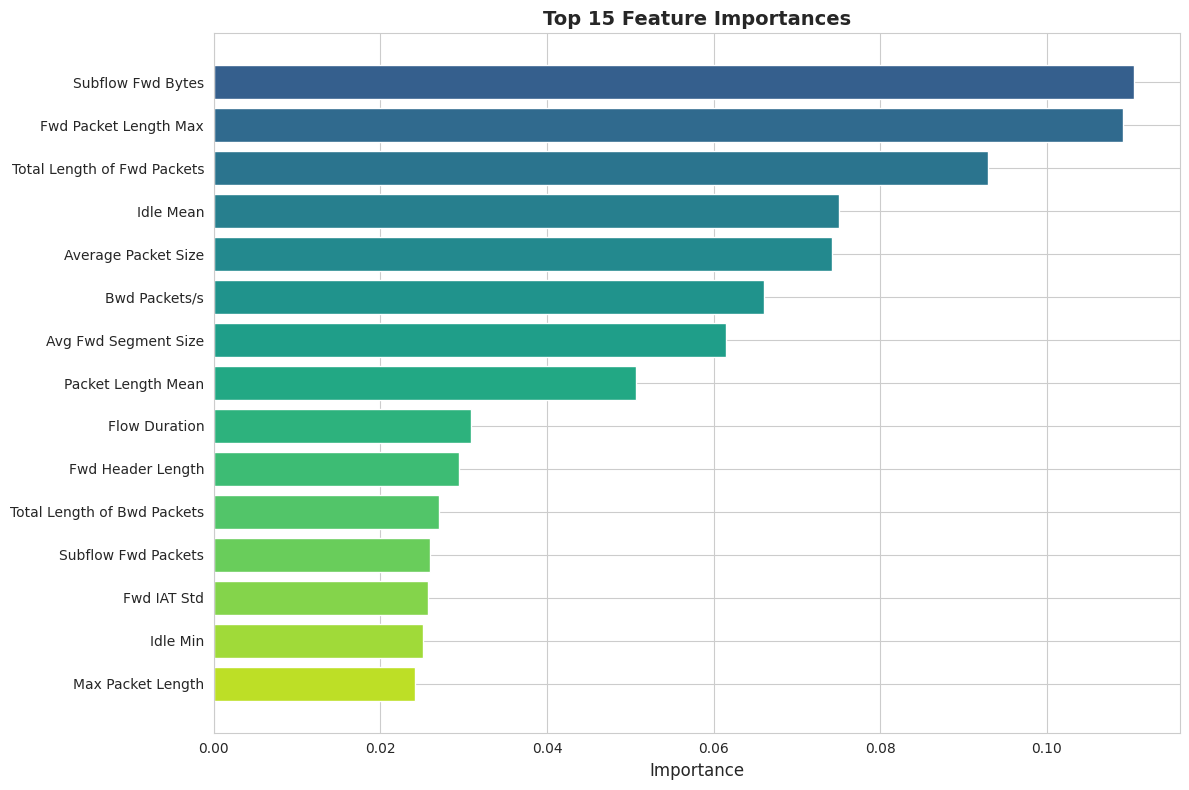

In [10]:
# Get feature importance
top_features = get_tree_feature_importance(
    rf_model,
    feature_names=list(dataset.data.columns),
    top_n=15,
    logger=logger
)

# Plot feature importance
features, importances = zip(*top_features)

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(features)))
plt.barh(range(len(features)), importances, color=colors)
plt.yticks(range(len(features)), features)
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()